In [60]:
import gcsfs
import joblib
import pandas as pd
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
import shap

shap.initjs()

spark = SparkSession.builder.getOrCreate()

In [2]:
def load_model(bucket_name, file_name):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f'{bucket_name}/{file_name}') as f:
        return joblib.load(f)

## 1. Preprocessing predictions to bring their feature matrix

To calculate the SHAP values I need to provide the feature metrix to the SHAP explainer class.
What I do here is:
1. Extract the highest scoring gene for each study/locus pair
2. Bring their feature matrix

In [26]:
window_highest_gene = Window.partitionBy('study_id', 'chrom', 'pos', 'ref', 'alt').orderBy(
         F.col('y_proba_full_model').desc()
)

predictions = (
    spark.read.parquet('data/predictions_2207').select('study_id', 'chrom', 'pos', 'ref', 'alt', 'gene_id', 'y_proba_full_model').distinct()
    # I want to interpret only the best scoring prediction
    .filter(F.col('y_proba_full_model') >= 0.05)
    .withColumn('best_scoring_pred_row_number', F.row_number().over(window_highest_gene))
    .filter(F.col('best_scoring_pred_row_number') == 1).drop('best_scoring_pred_row_number')

)

# Test. The highest scoring gene for this study/locus is SUGP1 (ENSG00000105705). That is what I get
predictions.filter(
    (F.col('chrom') == 19) & (F.col('pos') == 19296909) & (F.col('ref') == 'T') & (F.col('alt') == 'C') & (F.col('study_id') == 'GCST002222')
).orderBy(F.col('y_proba_full_model').desc()).show(5, False, True)



-RECORD 0--------------------------------
 study_id           | GCST002222         
 chrom              | 19                 
 pos                | 19296909           
 ref                | T                  
 alt                | C                  
 gene_id            | ENSG00000105705    
 y_proba_full_model | 0.5956910848617554 



In [27]:
# Join the features for each prediction

predictions_w_features = (
    predictions.join(
        spark.read.parquet('data/featurematrix_w_goldstandards.full.220712.parquet'),
        on=['study_id', 'chrom', 'pos', 'ref', 'alt', 'gene_id'], how='inner') # We have features for all predictions
    .distinct()
    .persist()
)

predictions_w_features.show(1, True, True)

-RECORD 0------------------------------------------
 study_id                   | FINNGEN_R6_AD_U_E... 
 chrom                      | 19                   
 pos                        | 44908684             
 ref                        | T                    
 alt                        | C                    
 gene_id                    | ENSG00000130203      
 y_proba_full_model         | 0.6877729892730713   
 dhs_prmtr_max              | 0.9122129999999999   
 dhs_prmtr_max_nbh          | 1.0                  
 dhs_prmtr_ave              | 0.9116864415135244   
 dhs_prmtr_ave_nbh          | 1.0                  
 enhc_tss_max               | null                 
 enhc_tss_max_nbh           | null                 
 enhc_tss_ave               | null                 
 enhc_tss_ave_nbh           | null                 
 eqtl_coloc_llr_max         | null                 
 eqtl_coloc_llr_max_neglogp | null                 
 eqtl_coloc_llr_max_nbh     | null                 
 sqtl_coloc_

In [24]:
# At this point I should have the highest scoring gene for each study/locus.

assert (
    predictions_w_features.select('study_id', 'chrom', 'pos', 'ref', 'alt', 'gene_id').distinct().count()
    == predictions_w_features.select('study_id', 'chrom', 'pos', 'ref', 'alt').distinct().count()
), 'There is more than one gene for one prediction.'


## 2. Calculate the SHAP values



## 1. Feature importance of the whole model

In [51]:
model_bucket = 'gs://genetics-portal-dev-staging/l2g/220712/models'
model_names = [f'xgboost-full_model-high_medium-{fold}.model.joblib.gz' for fold in range(5)]

models = [load_model(model_bucket, model_name) for model_name in model_names]
model_features = models[0]['run_info']['features']

[(model['run_info']['fold_num'], model['run_info']['fold_test_chroms']) for model in models]


[(0, {'1', '3', '8'}),
 (1, {'10', '16', '21', '22', '5', 'X'}),
 (2, {'11', '18', '20', '4', '9'}),
 (3, {'12', '17', '2', '7'}),
 (4, {'13', '14', '15', '19', '6'})]

In [74]:
X = list()

for model in models:
    # Slice the feature matrix for this fold
    X_fold = predictions_w_features.filter(F.col('chrom').isin(model['run_info']['fold_test_chroms'])).select(model_features).limit(50).toPandas()

    # Calculate the shap values for this fold
    explainer = shap.TreeExplainer(model['model'].best_estimator_)
    shap_values = explainer(X_fold)
    
    X.append(X_fold)
    print(f'{len(X_fold)} rows in model #{model["run_info"]["fold_num"]}')
    break

'''assert len(X) == len(models), 'The number of models and the number of folds do not match.'

X  = pd.concat(X, axis=0, ignore_index=True)
assert len(X) == len(predictions_w_features), 'The number of predictions and the number of features do not match.'

'''

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


60467 rows in model #0


"assert len(X) == len(models), 'The number of models and the number of folds do not match.'\n\nX  = pd.concat(X, axis=0, ignore_index=True)\nassert len(X) == len(predictions_w_features), 'The number of predictions and the number of features do not match.'\n\n"

In [109]:
type(X_fold.shap_values)

pandas.core.series.Series

In [91]:


shap.summary_plot(X_fold.shap_values.to_numpy(), X_fold.drop('shap_values', axis=1))

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [5]:
# The model is a dictionary containing the model itself + metadata

print(model.keys())
print('\n')
print(model['run_info'])
print('\n')
print(model['model'])
print('\n')
print(model['scores'])

dict_keys(['run_info', 'model', 'scores'])


{'classifier_name': 'xgboost', 'feature_name': 'full_model', 'features': ['dist_foot_min', 'dist_foot_min_nbh', 'dist_foot_ave', 'dist_foot_ave_nbh', 'dist_tss_min', 'dist_tss_min_nbh', 'dist_tss_ave', 'dist_tss_ave_nbh', 'eqtl_coloc_llr_max', 'eqtl_coloc_llr_max_neglogp', 'eqtl_coloc_llr_max_nbh', 'pqtl_coloc_llr_max', 'pqtl_coloc_llr_max_neglogp', 'pqtl_coloc_llr_max_nbh', 'eqtl_pics_clpp_max', 'eqtl_pics_clpp_max_neglogp', 'eqtl_pics_clpp_max_nhb', 'pqtl_pics_clpp_max', 'pqtl_pics_clpp_max_neglogp', 'pqtl_pics_clpp_max_nhb', 'dhs_prmtr_max', 'dhs_prmtr_max_nbh', 'dhs_prmtr_ave', 'dhs_prmtr_ave_nbh', 'enhc_tss_max', 'enhc_tss_max_nbh', 'enhc_tss_ave', 'enhc_tss_ave_nbh', 'pchicJung_max', 'pchicJung_max_nbh', 'pchicJung_ave', 'pchicJung_ave_nbh', 'vep_credset_max', 'vep_credset_max_nbh', 'vep_ave', 'vep_ave_nbh', 'polyphen_credset_max', 'polyphen_credset_max_nbh', 'polyphen_ave', 'polyphen_ave_nbh', 'count_credset_95', 'has_sumstats', 'gene

In [94]:
fm = (
    spark.read.parquet('data/featurematrix_w_goldstandards.full.220712.parquet')
    .filter(F.col('chrom').isin(['2', '7', '17', '12']))
    .select(model['run_info']['features'])
    .distinct()
    .limit(50)
)

fm.count()

50

In [95]:
explainer = shap.TreeExplainer(model['model'].best_estimator_)
shap_values = explainer(fm.toPandas())

ntree_limit is deprecated, use `iteration_range` or model slicing instead.      


In [103]:
## Exporting

import pickle

filename_shapv = 'shap_values_test.sav'
pickle.dump(shap_values, open(filename_shapv, 'wb'))

In [104]:
loaded_shapv = pickle.load(open(filename_shapv, 'rb'))

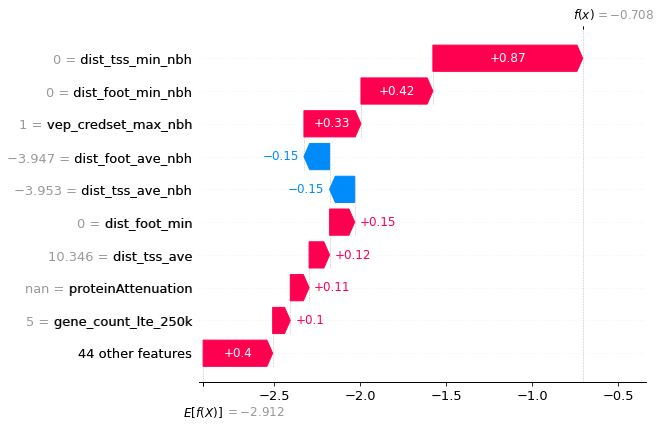

In [107]:
shap.plots.waterfall(shap_values[44])

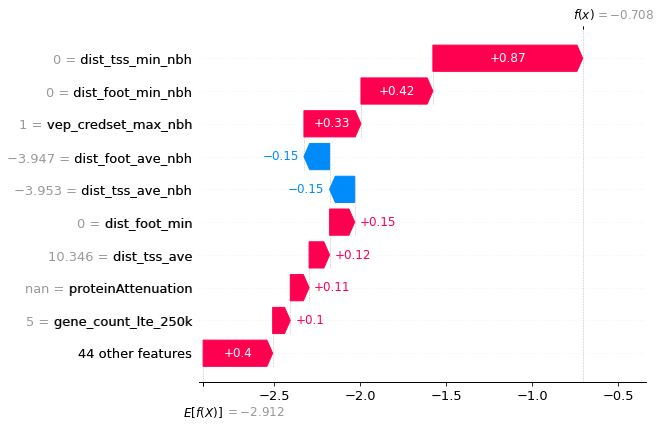

In [108]:
shap.plots.waterfall(loaded_shapv[44])

In [27]:
shap_values[43][3]

.values =
-0.12945382

.base_values =
-2.8976092

.data =
-3.5244120084510353

In [21]:
len(shap_values)

50

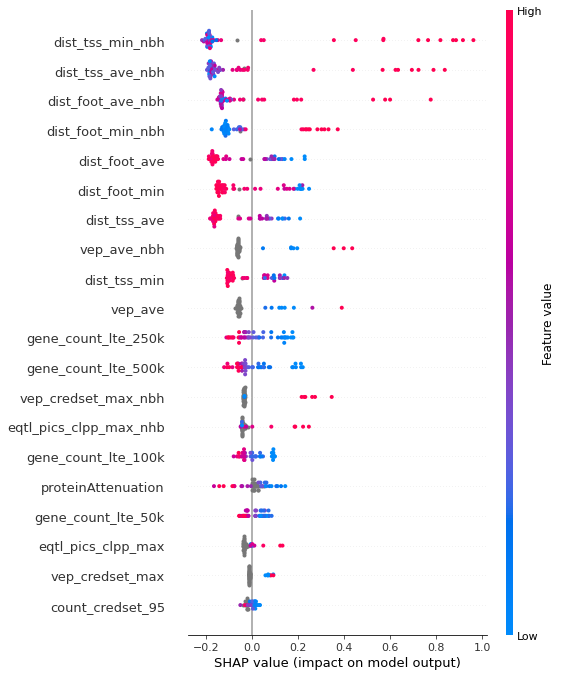

In [25]:
shap.summary_plot(shap_values, fm.toPandas())